In [1]:
import pandas as pd

In [2]:
import os
from scipy import io
import numpy as np
path = r'C:\Users\bumsung\Downloads\DEAP\DEAP\data_preprocessed_matlab/' # 경로는 저장 파일 경로
file_list = os.listdir(path)

for i in file_list:    # 확인
    print(i, end=' ')

s01.mat s02.mat s03.mat s04.mat s05.mat s06.mat s07.mat s08.mat s09.mat s10.mat s11.mat s12.mat s13.mat s14.mat s15.mat s16.mat s17.mat s18.mat s19.mat s20.mat s21.mat s22.mat s23.mat s24.mat s25.mat s26.mat s27.mat s28.mat s29.mat s30.mat s31.mat s32.mat 

In [11]:
mat_file = io.loadmat(path+'s01.mat')

In [4]:
mat_file['data'].shape

(40, 40, 8064)

In [5]:
mat_file['labels'].shape

(40, 4)

In [6]:
mat_file.keys()

dict_keys(['__header__', '__version__', '__globals__', 'labels', 'data'])

In [3]:
k=0

for i in file_list: 
    mat_file = io.loadmat(path+i)
    data = mat_file['data']
    labels = np.array(mat_file['labels'])
    val = labels.T[0].round().astype(np.int8)
    aro = labels.T[1].round().astype(np.int8)
    
    k+=1;
    print(k, end=' ')
    
    if(i=="s01.mat"): 
        Data = data
        VAL = val
        ARO = aro
        continue
        
    Data = np.concatenate((Data ,data),axis=0)   # 밑으로 쌓아서 하나로 만듬
    VAL = np.concatenate((VAL ,val),axis=0)
    ARO = np.concatenate((ARO ,aro),axis=0)

print('finish')

1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 finish


                 0
count  1280.000000
mean      5.235938
std       2.135508
min       1.000000
25%       4.000000
50%       5.000000
75%       7.000000
max       9.000000


C:\Users\bumsung\anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:ylabel='count'>

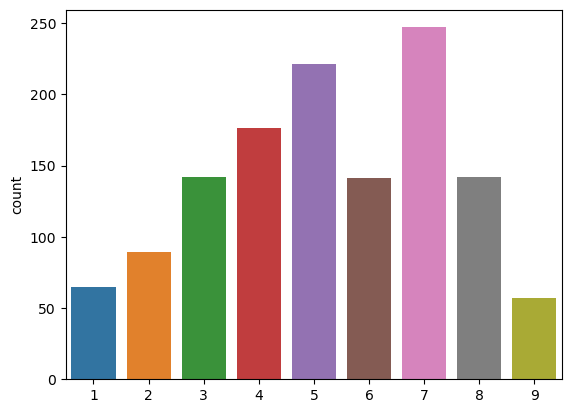

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
print(pd.DataFrame(VAL).describe())
sns.countplot(VAL)

In [28]:
data.shape
print(VAL)

[8 8 9 ... 3 4 7]


In [14]:
val.shape
from tensorflow.keras.utils import to_categorical

VAL_one = to_categorical(VAL-1, num_classes=9)

In [5]:
eeg_data = []
peripheral_data = []

for i in range(len(Data)):
    for j in range (40): 
        if(j < 32):
            eeg_data.append(Data[i][j])
        else:
            peripheral_data.append(Data[i][j])


In [13]:
eeg_data = np.reshape(eeg_data, (len(Data),1,32, 8064))
print(eeg_data.shape)
eeg_data=eeg_data.astype('float32')
eeg_data32 = torch.from_numpy(eeg_data)

(1280, 1, 32, 8064)


In [13]:
VAL.shape

(1280,)

data	40 x 40 x 8064	video/trial x channel x data

labels	40 x 4	video/trial x label (valence, arousal, dominance, liking)


In [14]:
val.shape

(40,)

### data split

In [27]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(eeg_data32, VAL, test_size=0.5)

In [28]:
print(x_train.shape)
print(x_test.shape)

torch.Size([640, 1, 32, 8064])
torch.Size([640, 1, 32, 8064])


In [5]:
pip install torch

Note: you may need to restart the kernel to use updated packages.


In [22]:
import torch.nn as nn
import torch
import torch.optim as optim

In [11]:
class Discriminator(nn.Module):
    def __init__(self, input_size):
        super().__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16,1)
        )
    
    def forward(self, x):
        return self.model(x)

In [12]:
class FC(nn.Module):
    def __init__(self, channel_size, flatten_size=15960, cls_num=9):
        super().__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(1,30,kernel_size=(1,25)),
            nn.Conv2d(30,30, kernel_size=(channel_size, 1)),
            nn.AvgPool2d(kernel_size=(1, 75), stride=15),
            nn.Flatten()
        )
        
        self.fc = nn.Sequential(
            nn.Linear(flatten_size, 64),
            nn.ReLU(),
            nn.Linear(64, 16),
            nn.ReLU(),
            nn.Linear(16, cls_num)
        )
        
        
    def forward(self, x):
        
        feat = self.conv(x)
        pred = self.fc(feat)
        
        return feat, pred
        

fc = FC(32)        

In [19]:
eeg_data.shape

(1280, 1, 32, 8064)

In [20]:
x_train.dtype

dtype('float32')

Default float in Numpy is float64, you must convert the Numpy tensor to np.float32 before converting it to Pytorch.

https://growthvalue.tistory.com/229 
- ram 크기 문제

In [18]:
feat, pred = fc.forward(eeg_data32[:10])
print(feat.shape)
print(pred.shape)

torch.Size([10, 15960])
torch.Size([10, 9])


In [21]:
dis = Discriminator(feat.shape[1])
print(dis.forward(feat))

tensor([[0.1434],
        [0.1446],
        [0.1465],
        [0.1402],
        [0.1437],
        [0.1480],
        [0.1477],
        [0.1416],
        [0.1551],
        [0.1463]], grad_fn=<AddmmBackward0>)


At each iteration, we first update the parameters of the domain discriminator, fix the feature extractor and classifier, and then fix the domain discriminator and update the parameters of both the feature extractor and classifier.
- 검열기 역전파 / 나머지 고정
- 검열기 고정 / 나머지 역전파

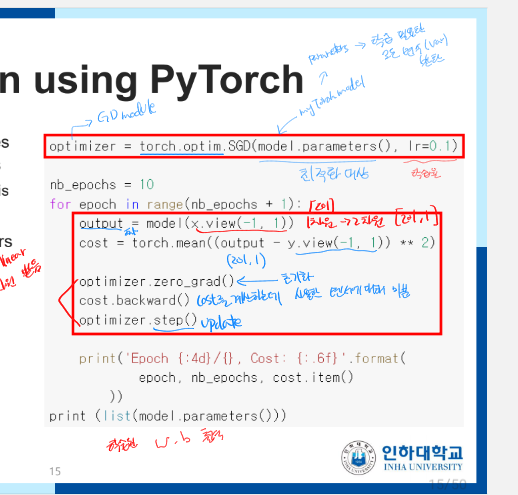

In [31]:
feat_t, pred_t = fc.forward(x_train[:10])
feat_s, pred_s = fc.forward(x_test[:10])
print(feat.shape, pred.shape)

torch.Size([10, 15960]) torch.Size([10, 9])


In [32]:
#optim
optimizer_dis = optim.SGD(dis.parameters(), lr=0.001, momentum=0.9)
optimizer_cls = optim.SGD(fc.parameters(), lr=0.001, momentum=0.9)

In [33]:
#loss_cls
def loss_dis(pred_t, pred_s):
    return torch.mean(torch.square(pred_t-1)+tf.square(pred_s)) / 2 

In [38]:
optimizer_dis.zero_grad()

dis = Discriminator(15960)
DT = dis(feat_t)
DS = dis(feat_s)

In [55]:
g_loss_adv = torch.mean(torch.square(DS-1))/2
g_loss_ce_t = torch.log(torch.sum(torch.exp(pred_t)))-pred_t[y_train[:10]-1]
g_loss_ce_s = torch.log(torch.sum(torch.exp(pred_t)))-pred_t[y_train[:10]-1]

In [58]:
g_loss_ce_s.shape

torch.Size([10, 9])

In [63]:
DT.shape

torch.Size([10, 1])

In [65]:
g_loss_adv.shape

torch.Size([])